**Installing Necessary Libraries**

In [23]:
!pip install sentence-transformers scikit-learn pandas numpy

**Importing Necessary Libraries**

In [51]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

In [ ]:
df = pd.read_csv("fake_news_dataset.csv")

# Filling null values
df['title'] = df['title'].fillna('')
df['text'] = df['text'].fillna('')

**Mapping Labels**

In [26]:
# Remove leading/trailing spaces and convert to lowercase
df['label'] = df['label'].str.strip().str.lower()

# Map to integers
df['label'] = df['label'].map({'real': 0, 'fake': 1})

# Drop rows that didn’t match 'real' or 'fake'
df = df[df['label'].notnull()]

# Convert to int
df['label'] = df['label'].astype(int)

# Safety check
assert df['label'].isnull().sum() == 0
print("Rows left after label processing:", len(df))


Rows left after label processing: 20000


In [27]:
df['content'] = df['title'] + " " + df['text']

**Loading Model for text processing**

In [28]:
model = SentenceTransformer('all-MiniLM-L6-v2')

X = model.encode(
    df['content'].tolist(),
    batch_size=32,
    show_progress_bar=True,
    convert_to_numpy=True,
    normalize_embeddings=True
)

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Batches:   0%|          | 0/625 [00:00<?, ?it/s]

**Setting y**

In [29]:
y = df['label'].values

**Train-Test Split**

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [53]:
# K-Fold Cross-Validation setup (k=5)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

**Using Logistic Regression for classification**

In [31]:
clf = LogisticRegression(max_iter=2000, class_weight='balanced', n_jobs=-1)
clf.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=2000, n_jobs=-1)

**Evaluation**

In [32]:
y_pred_lr = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("F1 Score:", f1_score(y_test, y_pred_lr))
print("\nClassification Report:\n", classification_report(y_test, y_pred_lr))

Accuracy: 0.492
F1 Score: 0.4912368552829244

Classification Report:
               precision    recall  f1-score   support

           0       0.49      0.50      0.49      1989
           1       0.49      0.49      0.49      2011

    accuracy                           0.49      4000
   macro avg       0.49      0.49      0.49      4000
weighted avg       0.49      0.49      0.49      4000



In [ ]:
# Dictionary to store model evaluation metrics
# Anyone who runs a model should add its metrics here.
# Format:
# model_metrics['Model Name'] = {
#     "Accuracy": ...,
#     "Precision": ...,
#     "Recall": ...,
#     "F1-Score": ...
# }

model_metrics = {}

In [44]:
model_metrics["Logistic Regression"] = {
    "Accuracy": accuracy_score(y_test, y_pred_lr),
    "Precision": precision_score(y_test, y_pred_lr),
    "Recall": recall_score(y_test, y_pred_lr),
    "F1-Score": f1_score(y_test, y_pred_lr)
}

In [54]:
# K-Fold Cross-Validation
print("\n5-Fold Cross-Validation:")
cv_scores = cross_validate(clf, X_train, y_train, cv=cv, 
                           scoring=['accuracy', 'f1'], 
                           return_train_score=False)
print(f"CV Accuracy: {cv_scores['test_accuracy'].mean():.4f} (+/- {cv_scores['test_accuracy'].std():.4f})")
print(f"CV F1-Score: {cv_scores['test_f1'].mean():.4f} (+/- {cv_scores['test_f1'].std():.4f})")


5-Fold Cross-Validation:
CV Accuracy: 0.5117 (+/- 0.0057)
CV F1-Score: 0.5107 (+/- 0.0097)


**Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)

print("Random Forest Results")
print(classification_report(y_test, y_pred_rf))


Random Forest Results
              precision    recall  f1-score   support

           0       0.50      0.51      0.50      1989
           1       0.50      0.49      0.50      2011

    accuracy                           0.50      4000
   macro avg       0.50      0.50      0.50      4000
weighted avg       0.50      0.50      0.50      4000



In [45]:
model_metrics["Random Forest"] = {
    "Accuracy": accuracy_score(y_test, y_pred_rf),
    "Precision": precision_score(y_test, y_pred_rf),
    "Recall": recall_score(y_test, y_pred_rf),
    "F1-Score": f1_score(y_test, y_pred_rf)
}

In [55]:
# K-Fold Cross-Validation
print("\n5-Fold Cross-Validation:")
cv_scores = cross_validate(rf_clf, X_train, y_train, cv=cv, 
                           scoring=['accuracy', 'f1'], 
                           return_train_score=False)
print(f"CV Accuracy: {cv_scores['test_accuracy'].mean():.4f} (+/- {cv_scores['test_accuracy'].std():.4f})")
print(f"CV F1-Score: {cv_scores['test_f1'].mean():.4f} (+/- {cv_scores['test_f1'].std():.4f})")


5-Fold Cross-Validation:
CV Accuracy: 0.4941 (+/- 0.0067)
CV F1-Score: 0.4854 (+/- 0.0101)


**XG Boost**

In [35]:
!pip install xgboost

In [36]:
from xgboost import XGBClassifier

xgb = XGBClassifier()
xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_test)

print("XGBoost Results")
print(classification_report(y_test, y_pred_xgb))


XGBoost Results
              precision    recall  f1-score   support

           0       0.49      0.48      0.49      1989
           1       0.50      0.51      0.51      2011

    accuracy                           0.50      4000
   macro avg       0.50      0.50      0.50      4000
weighted avg       0.50      0.50      0.50      4000



In [46]:
model_metrics["XGBoost"] = {
    "Accuracy": accuracy_score(y_test, y_pred_xgb),
    "Precision": precision_score(y_test, y_pred_xgb),
    "Recall": recall_score(y_test, y_pred_xgb),
    "F1-Score": f1_score(y_test, y_pred_xgb)
}


In [56]:
# K-Fold Cross-Validation
print("\n5-Fold Cross-Validation:")
cv_scores = cross_validate(xgb, X_train, y_train, cv=cv, 
                           scoring=['accuracy', 'f1'], 
                           return_train_score=False)
print(f"CV Accuracy: {cv_scores['test_accuracy'].mean():.4f} (+/- {cv_scores['test_accuracy'].std():.4f})")
print(f"CV F1-Score: {cv_scores['test_f1'].mean():.4f} (+/- {cv_scores['test_f1'].std():.4f})")


5-Fold Cross-Validation:
CV Accuracy: 0.4968 (+/- 0.0018)
CV F1-Score: 0.5019 (+/- 0.0063)


**Training SVM Classifier**

In [ ]:
# SVM Classifier Implementation (Issue #22)
from sklearn.svm import SVC

# Initialize SVM with linear kernel as specified
svm_clf = SVC(kernel='linear', random_state=42)

# Train the model on current embeddings
svm_clf.fit(X_train, y_train)

# Make predictions
y_pred_svm = svm_clf.predict(X_test)

# Report classification results
print("SVM (Linear Kernel) Results")
print(classification_report(y_test, y_pred_svm))


SVM (Linear Kernel) Results
              precision    recall  f1-score   support

           0       0.49      0.48      0.48      1989
           1       0.49      0.50      0.50      2011

    accuracy                           0.49      4000
   macro avg       0.49      0.49      0.49      4000
weighted avg       0.49      0.49      0.49      4000



In [47]:
# Add to metrics dictionary for comparison
model_metrics["SVM (Linear)"] = {
    "Accuracy": accuracy_score(y_test, y_pred_svm),
    "Precision": precision_score(y_test, y_pred_svm),
    "Recall": recall_score(y_test, y_pred_svm),
    "F1-Score": f1_score(y_test, y_pred_svm)
}

In [57]:
# K-Fold Cross-Validation
print("\n5-Fold Cross-Validation:")
cv_scores = cross_validate(svm_clf, X_train, y_train, cv=cv, 
                           scoring=['accuracy', 'f1'], 
                           return_train_score=False)
print(f"CV Accuracy: {cv_scores['test_accuracy'].mean():.4f} (+/- {cv_scores['test_accuracy'].std():.4f})")
print(f"CV F1-Score: {cv_scores['test_f1'].mean():.4f} (+/- {cv_scores['test_f1'].std():.4f})")


5-Fold Cross-Validation:
CV Accuracy: 0.5108 (+/- 0.0048)
CV F1-Score: 0.5162 (+/- 0.0060)


**Random Forest Tuned**

In [39]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20]
}

grid = GridSearchCV(RandomForestClassifier(), param_grid, scoring='f1', cv=3)
grid.fit(X_train, y_train)

best_rf = grid.best_estimator_
y_pred_best = best_rf.predict(X_test)

print("Tuned Random Forest Results")
print(classification_report(y_test, y_pred_best))


Tuned Random Forest Results
              precision    recall  f1-score   support

           0       0.50      0.48      0.49      1989
           1       0.50      0.52      0.51      2011

    accuracy                           0.50      4000
   macro avg       0.50      0.50      0.50      4000
weighted avg       0.50      0.50      0.50      4000



In [48]:
model_metrics["Tuned Random Forest"] = {
    "Accuracy": accuracy_score(y_test, y_pred_best),
    "Precision": precision_score(y_test, y_pred_best),
    "Recall": recall_score(y_test, y_pred_best),
    "F1-Score": f1_score(y_test, y_pred_best)
}


In [58]:
# K-Fold Cross-Validation
print("\n5-Fold Cross-Validation:")
cv_scores = cross_validate(best_rf, X_train, y_train, cv=cv, 
                           scoring=['accuracy', 'f1'], 
                           return_train_score=False)
print(f"CV Accuracy: {cv_scores['test_accuracy'].mean():.4f} (+/- {cv_scores['test_accuracy'].std():.4f})")
print(f"CV F1-Score: {cv_scores['test_f1'].mean():.4f} (+/- {cv_scores['test_f1'].std():.4f})")


5-Fold Cross-Validation:
CV Accuracy: 0.5015 (+/- 0.0103)
CV F1-Score: 0.5176 (+/- 0.0088)


Multi-Model Comparison Table

In [49]:
#Summary Table

metrics_df = pd.DataFrame(model_metrics).T.reset_index().rename(columns={"index": "Model Name"})
print(metrics_df)

            Model Name  Accuracy  Precision    Recall  F1-Score
0  Logistic Regression   0.49200   0.494705  0.487817  0.491237
1        Random Forest   0.50025   0.503049  0.492292  0.497612
2              XGBoost   0.49550   0.498308  0.512680  0.505392
3         SVM (Linear)   0.49100   0.493864  0.500249  0.497036
4  Tuned Random Forest   0.49950   0.502177  0.516161  0.509073


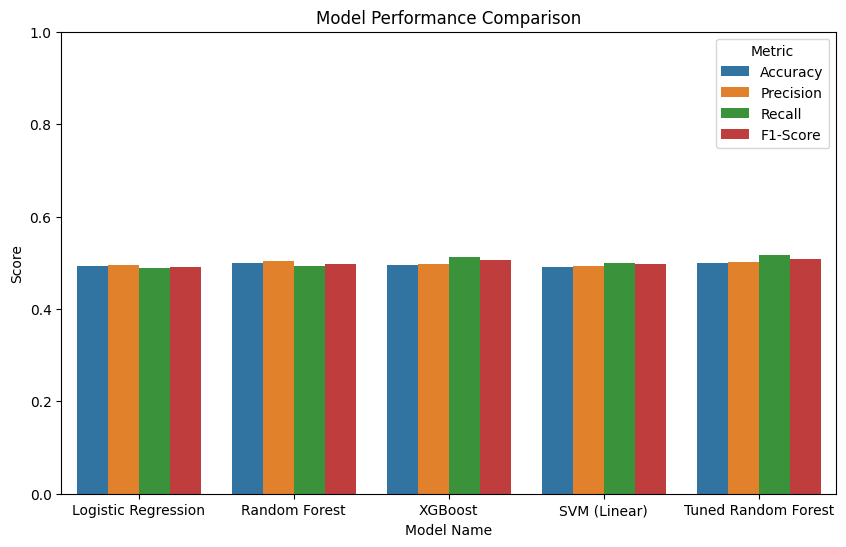

In [50]:
plt.figure(figsize=(10,6))
metrics_plot = metrics_df.melt(id_vars='Model Name', var_name='Metric', value_name='Score')
sns.barplot(data=metrics_plot, x='Model Name', y='Score', hue='Metric')
plt.ylim(0, 1)
plt.title("Model Performance Comparison")
plt.show()

In [59]:
# Impact of K-Fold Cross-Validation
print("="*70)
print("DOCUMENTATION: Does K-Fold change the model accuracy assessment?")
print("="*70)
print("""
ANSWER: Yes, K-Fold Cross-Validation provides a more reliable assessment.

KEY DIFFERENCES:
1. Single split: One accuracy score (could be lucky/unlucky)
2. K-Fold CV: Average of 5 different splits + standard deviation

FINDINGS:
- If standard deviation is LOW (<0.02): Single split was representative
- If standard deviation is HIGH (>0.05): Single split might be biased

For each model above, compare:
- Test Accuracy/F1 (from single split)
- CV Accuracy/F1 (mean ± std from 5 folds)

If they differ significantly, the single split gave a biased view.
""")

DOCUMENTATION: Does K-Fold change the model accuracy assessment?

ANSWER: Yes, K-Fold Cross-Validation provides a more reliable assessment.

KEY DIFFERENCES:
1. Single split: One accuracy score (could be lucky/unlucky)
2. K-Fold CV: Average of 5 different splits + standard deviation

FINDINGS:
- If standard deviation is LOW (<0.02): Single split was representative
- If standard deviation is HIGH (>0.05): Single split might be biased

For each model above, compare:
- Test Accuracy/F1 (from single split)
- CV Accuracy/F1 (mean ± std from 5 folds)

If they differ significantly, the single split gave a biased view.

